Best parameters: {'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
CV accuracy: 0.89
Test accuracy: 0.88


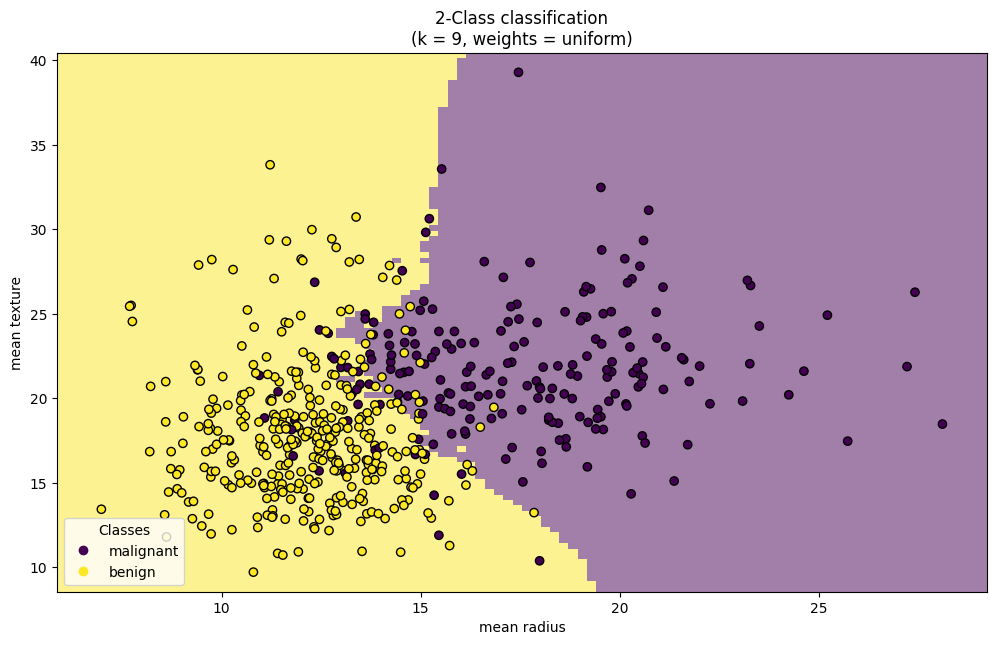

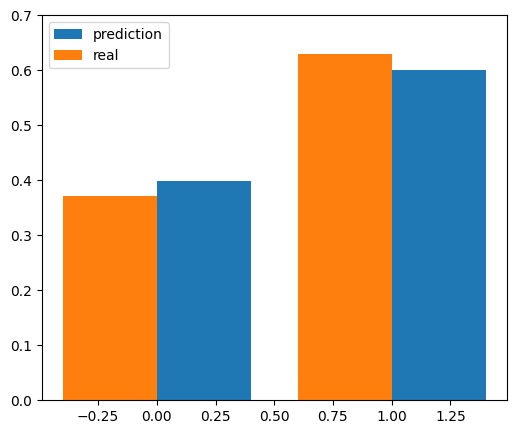

AUC: 0.94


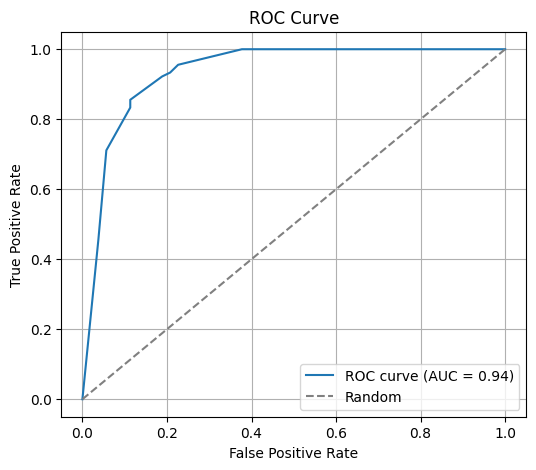

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

br_cancer = load_breast_cancer(as_frame=True)
X = br_cancer.data[["mean radius", "mean texture"]]
y = br_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
)

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"]
}

clf_grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
clf_grid.fit(X_train, y_train)

print("Best parameters:", clf_grid.best_params_)
print(f"CV accuracy: {clf_grid.best_score_:.2f}")

clf_best = clf_grid.best_estimator_
y_pred = clf_best.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.2f}")

_, ax = plt.subplots(ncols=1, figsize=(12, 7))
disp = DecisionBoundaryDisplay.from_estimator(
        clf_best,
        X,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=br_cancer.feature_names[0],
        ylabel=br_cancer.feature_names[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )

scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
disp.ax_.legend(
        scatter.legend_elements()[0],
        br_cancer.target_names,
        loc="lower left",
        title="Classes",
    )

_ = disp.ax_.set_title(
        f"2-Class classification\n(k = {clf_grid.best_params_['knn__n_neighbors']}, weights = {clf_grid.best_params_['knn__weights']})"
    )

plt.show()

y_proba = clf_best.predict_proba(X_test)
unique, freq = np.unique(y_test, return_counts=True)
freq = list(map(lambda x: x / len(y_test),freq))

pred_freq = y_proba.mean(axis=0)
plt.figure(figsize=(6, 5))
plt.bar(range(len(pred_freq)), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(len(pred_freq)), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.7)
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])

auc = roc_auc_score(y_test, y_proba[:, 1])
print(f"AUC: {auc:.2f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()